In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/leasaab/Documents/Dev/AX3-Project/data/FemmeCardio.csv"

data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

# Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Handle invalid dates

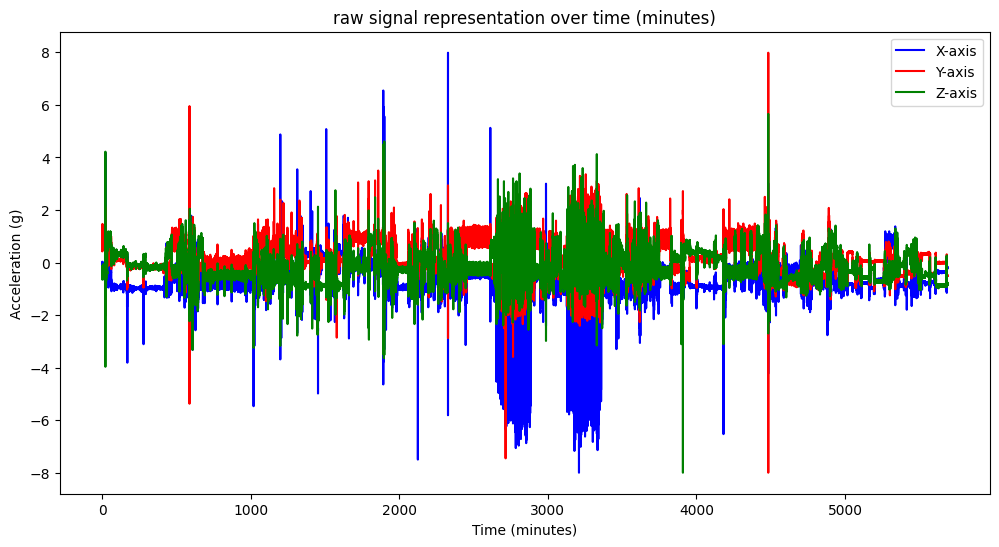

In [5]:


# Calculate the sampling interval (in seconds)
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  # Access a single row
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_minutes'] = data.index * sampling_interval

# Define axis labels for clarity
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'blue', 'Y': 'red', 'Z': 'green'}  # Define colors for each signal

# Plot the signal with corrected legends
plt.figure(figsize=(12, 6))
for signal, axis_label, color in zip(signal_columns, axis_labels, colors.values()):
    plt.plot(data['relative_time_minutes'], data[signal], label=axis_label, color=color)

plt.title("raw signal representation over time (minutes)")
plt.xlabel("Time (minutes)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.show()

# Low-pass filter function:

In [6]:
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

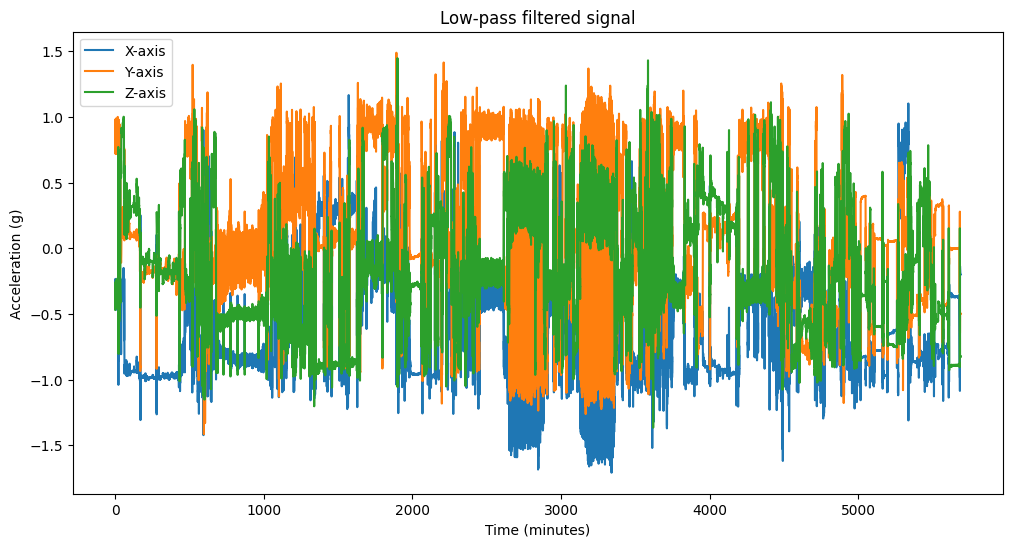

In [7]:
# Define sampling frequency (fs) and cutoff frequency
fs = 1 / (sampling_interval)  # Sampling frequency in Hz (based on time in minutes)
cutoff = 2  # Low-pass filter cutoff frequency in Hz
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']  # Correctly labeled for legend

# Apply the filter directly to the original filtered_data DataFrame
for signal in signal_columns:
    data[signal] = lowpass_filter(data[signal], cutoff, fs)

# Plot the low-pass filtered signals directly from filtered_data
plt.figure(figsize=(12, 6))
for signal, axis_label in zip(signal_columns, axis_labels):  # Use axis_labels for legend
    plt.plot(data['relative_time_minutes'], data[signal], label=axis_label)

plt.title("Low-pass filtered signal")
plt.xlabel("Time (minutes)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.show()

Nombre total de pics détectés : 2564
Intervalle moyen entre les pics : 2.09 minutes
Cadence moyenne : 88.57 pas par minute


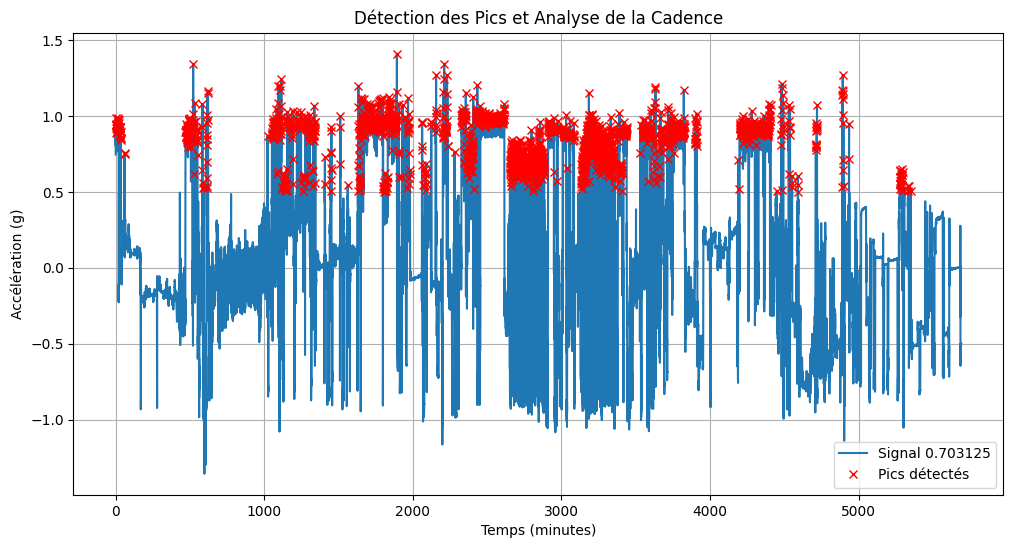

In [14]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Sélectionner l'axe avec la plus grande variance
signal_columns = data.columns[1:-1]  # Exclure le timestamp et le temps relatif
variances = data[signal_columns].var()
selected_axis = variances.idxmax()

# Détecter les pics dans le signal filtré
# Les paramètres 'height' et 'distance' peuvent nécessiter des ajustements en fonction des données
peaks, _ = find_peaks(data[selected_axis], height=0.5, distance=fs*0.1)  # Par exemple, pics à au moins 0.5g et espacés de 0.5 seconde

# Calculer les temps associés aux pics détectés
peak_times = data['relative_time_minutes'].iloc[peaks]

# Calculer les intervalles entre les pics (en minutes)
intervals = peak_times.diff().dropna()

# Calculer la cadence (pas par seconde)
cadence_per_second = 1 / intervals

# Convertir la cadence en pas par minute
cadence_per_minute = cadence_per_second * 60

# Afficher les statistiques
print(f"Nombre total de pics détectés : {len(peaks)}")
print(f"Intervalle moyen entre les pics : {intervals.mean():.2f} minutes")
print(f"Cadence moyenne : {cadence_per_minute.mean():.2f} pas par minute")

# Visualiser le signal et les pics détectés
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data[selected_axis], label=f"Signal {selected_axis}")
plt.plot(peak_times, data[selected_axis].iloc[peaks], "x", label="Pics détectés", color='red')
plt.title("Détection des Pics et Analyse de la Cadence")
plt.xlabel("Temps (minutes)")
plt.ylabel("Accélération (g)")
plt.legend()
plt.grid(True)
plt.show()